In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=640):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "Images", id_name)
        mask_path = os.path.join(self.path, "Mask", id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.image_size, self.image_size))

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.ids):
            files_batch = self.ids[index*self.batch_size : len(self.ids)]
        else:
            files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        # print("files_batch: ", files_batch)
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [3]:
image_size = 640
train_path = "dataset_copy_3_imgs/train/"
valid_path = "dataset_copy_3_imgs/valid/"
epochs = 3
batch_size = 1

## Training Ids
train_ids = os.listdir(train_path + "Images")
valid_ids = os.listdir(valid_path + "Images")
print(len(train_ids), train_ids)
print(len(valid_ids), valid_ids)


3 ['2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']
1 ['11_jpg.rf.2e71343ba8845ca7db0b208ae1a6b064.jpg']


In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
x, y = gen.__getitem__(1)
print(x.shape, y.shape)

(1, 640, 640, 1) (1, 640, 640, 1)
(1, 640, 640, 1) (1, 640, 640, 1)


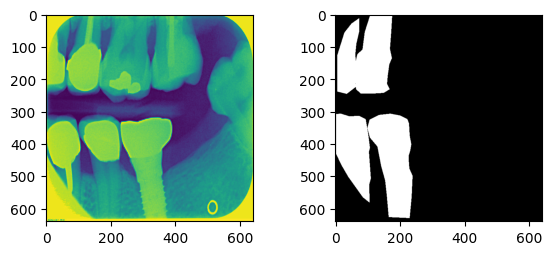

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [7]:
def UNet():
    f = [80, 160, 320, 640, 1280]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #
    c2, p2 = down_block(p1, f[1]) #
    c3, p3 = down_block(p2, f[2]) #
    c4, p4 = down_block(p3, f[3]) #
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #
    u2 = up_block(u1, c3, f[2]) #
    u3 = up_block(u2, c2, f[1]) #
    u4 = up_block(u3, c1, f[0]) #
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
 Layer (type)                 Output Shape                  Param #   Connected to                  
 input_1 (InputLayer)         [(None, 640, 640, 1)]         0         []                            
                                                                                                    
 conv2d (Conv2D)              (None, 640, 640, 80)          800       ['input_1[0][0]']             
                                                                                                    
 conv2d_1 (Conv2D)            (None, 640, 640, 80)          57680     ['conv2d[0][0]']              
                                                                                                    
 max_pooling2d (MaxPooling2D  (None, 320, 320, 80)          0         ['conv2d_1[0][0]']            
 )                                                                          

## Training the model

In [9]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, valid_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(train_steps, valid_steps)

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)


3 1


C:\Users\user\AppData\Local\Temp\ipykernel_15160\59060332.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model/conv2d_16/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 87, in _run_code

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\user\AppData\Local\Temp\ipykernel_15160\59060332.py", line 8, in <module>

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2889, in fit_generator

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1130, in train_step

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize

  File "c:\Users\user\Desktop\Teeth-Unet\.venv\lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[1,409600,2160] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model/conv2d_16/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4892]

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
test_path = "dataset_copy/test/"
test_ids = os.listdir(test_path + "/Images")
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)
x, y = test_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")